# Minimum Step Control System

Minimum step control system includes a pattern control system and no pattern control system, it belongs to one of the discrete control system, which aims to enter in the 3 typical digital controller is designed under the system and take the minimum and limited the number of end Control process, and do not in the sampling error of the moment, so take control of the minimum number of control system design in the design of this controller design is an important part of the design. In the digital control system which, in the complex plane Z domain to achieve a stable, non-error control can be achieved.(from [Minimum Step Control System Design](https://link.springer.com/chapter/10.1007/978-3-642-21697-8_21))

Consider following $G(s)$, try to design minimum step controller $D(z)$ for ramp input $r(t)=\frac{1}{2}t^2$

$$
G(s)=\frac{1}{s(s+1)}
$$

In [1]:
import control as co;
import matplotlib.pyplot as plt;
import numpy as np;

## Convert continuous time system to discrete time by sampling

从对象离散化后的传递函数可以发现，对象在z平面单位圆上（（1，0）点除外）或圆外无零点和极点，而且没有纯滞后环节。
可以应用简单对象的最小拍系统设计方法


In [2]:
Gs=co.tf(1,np.convolve([1,0],[1,1]))
Ts=0.1
Wd=co.c2d(Gs,Ts,method='zoh')
poles,zeros=co.pzmap(Wd,plot=False)
print('G(z)=',Wd)
print("G(z) has %d poles: %s and %d zeros:%s" % (len(poles),poles,len(zeros),zeros))

G(z)= 
0.004837 z + 0.004679
----------------------
z^2 - 1.905 z + 0.9048

dt = 0.1

G(z) has 2 poles: [1.         0.90483742] and 1 zeros:[-0.96721849]


## Minimum Step System with Pattern

In [3]:
z=co.tf('z')
We=(1-z**(-1))**2
WB=1-We
D=co.minreal(WB/(Wd*We))
print('close-loop transfer function should be\nWB=',WB)
print("The controller's transfer function should be:\nD=",D)

3 states have been removed from the model
close-loop transfer function should be
WB= 
2 z - 1
-------
  z^2

The controller's transfer function should be:
D= 
413.4 z^2 - 580.8 z + 187
-------------------------
z^2 - 0.03278 z - 0.9672

dt = 0.1



The system need 2 step(s) to follow input


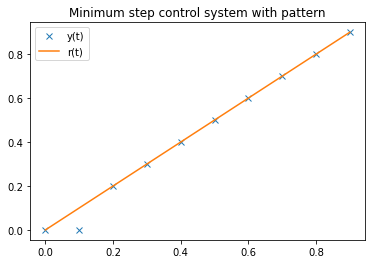

In [4]:
t=np.arange(0,1,0.1)
r=t
t,y=co.forced_response(WB,t,U=r)
e=r-y
for i in range(1,len(e)-1):
    if e[i] < 0.01:
        print("The system need %d step(s) to follow input" % (i))
        break
plt.plot(t,y,'x',t,r,'-')
plt.title('Minimum step control system with pattern')
plt.legend(['y(t)','r(t)'])
plt.show()


## Minimum Step system with no pattern

在有纹系统的基础上，无纹波系统还需要满足系统包含对象所有零点的条件

$$
WB=(f_1 z^{-1}+f_2 z^{-2})(1+\beta z^{-1})
$$

In [5]:
beta=-1*zeros[0]
f1=(2+3*beta)/(1+beta)**2
f2=-1*(1+2*beta)/(1+beta)**2
WB=(f1*z**(-1)+f2*z**(-2))*(1+beta*z**(-1))

The system need 3 step(s) to follow input


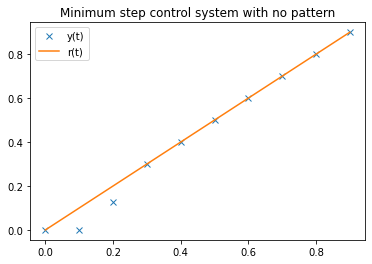

In [6]:
t=np.arange(0,1,0.1)
r=t
t,y=co.forced_response(WB,t,U=r)
e=r-y
for i in range(1,len(e)-1):
    if e[i] < 0.01:
        print("The system need %d step(s) to follow input" % (i))
        break
plt.plot(t,y,'x',t,r,'-')
plt.title('Minimum step control system with no pattern')
plt.legend(['y(t)','r(t)'])
plt.show()

# add Damp to improve Performance

通过增加阻尼因子配置极点，系统跟随原输入信号的性能速度会稍有下降，但可以明显改善系统对于其他阶次信号的性能。

- 当输入信号的阶次比设计时输入信号的阶次小时，虽然快速性也有所下降，但是超调量得到了很好的抑制
- 当输入信号比原信号阶次大时，系统稳态误差会有所上升。

$$
W_B(z)=\frac{f_1z^{-1}+f_2z^{-2}}{1-cz^{-1}}
$$


In [7]:
def WB_addDamp(c):
    #from blue book P151
    f1=2-c;f2=-1
    WB3=(f1*z**(-1)+f2*z**(-2))/(1-c*z**(-1))
    return WB3

### follow Velocity Input

增加阻尼因子后，响应速度变慢，需要更多拍数

damp: 0.000 step(s):  2	max error:0.100
damp: 0.225 step(s):  3	max error:0.100
damp: 0.450 step(s):  4	max error:0.100
damp: 0.675 step(s):  7	max error:0.100
damp: 0.900 step(s): 23	max error:0.100


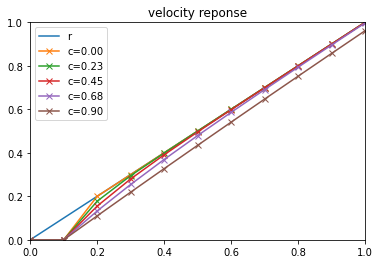

In [8]:
plt.figure()
t=np.arange(0,10,0.1)
r=t
plt.plot(t,r,'-',label="r")
for c in np.linspace(0,0.9,5):
    WB=WB_addDamp(c)
    t,y=co.forced_response(WB,t,U=r)
    e=r-y
    plt.plot(t,y,'x-',label="c={:.2f}".format(c))
    for i in range(1,len(e)-1):
        if e[i] <0.01:
            print("damp: %.3f step(s):%3d\tmax error:%-.3f" % (c,i,max(e)))
            break
plt.xlim([0,1]);plt.ylim([0,1])
plt.title("velocity reponse")
plt.legend();plt.show()



### follow Step Input

当输入信号比设计时的信号阶次小时，系统的超调得到了很好地一致，
阻尼因子越大，超调越小，但是跟随所需要的拍数也会增大，快速性下降

damp: 0.000 step(s):  2 overshoot:100.0%
damp: 0.225 step(s):  4 overshoot:77.5%
damp: 0.450 step(s):  7 overshoot:55.0%
damp: 0.675 step(s): 10 overshoot:32.5%
damp: 0.900 step(s): 23 overshoot:10.0%


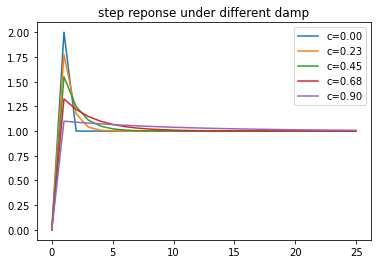

In [9]:
plt.figure()
for c in np.linspace(0,0.9,5):
    WB=WB_addDamp(c)
    t,y=co.step_response(WB)
    e=1-y
    plt.plot(t,y,'-',label="c={:.2f}".format(c))
    overshoot=max(y-1)/1
    for i in range(1,len(e)-1):
        if abs(y[i]-1) < 0.01:
            print("damp: %.3f step(s):%3d overshoot:%-3.1f%%" % (c,i,overshoot*100))
            break
plt.title("step reponse under different damp")
plt.legend();plt.show()

### follow Acceleration Input

当输入的信号阶次比设计时的大时，阻尼因子越大，响应的稳态误差越大

The system with damp 0.000 has ess= 0.010
The system with damp 0.225 has ess= 0.013
The system with damp 0.450 has ess= 0.018
The system with damp 0.675 has ess= 0.031
The system with damp 0.900 has ess= 0.100


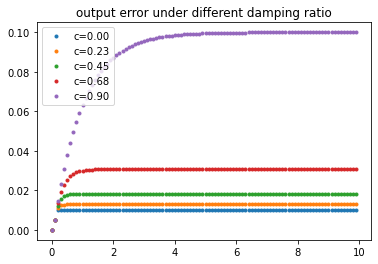

In [10]:
plt.figure()
t=np.arange(0,10,0.1)
r=1/2*t**2
for c in np.linspace(0,0.9,5):
    WB=WB_addDamp(c)
    t,y=co.forced_response(WB,t,U=r)
    e=r-y
    plt.plot(t,e,'.',label="c={:.2f}".format(c))
    print("The system with damp %.3f has ess= %.3f" % (c,e[-1]))
plt.title('output error under different damping ratio')
plt.legend();plt.show()